In [1]:
import pandas as pd
import numpy as np
import glob
from anndata import AnnData
import scanpy as sc
import lifelines as ls
import matplotlib.pyplot as plt
import seaborn as sns

# _Summary_

_This report examines whether liver cancer patients' with different survival time is correlated with distinct genomic subgroups. Three distinct clusters are formed through dimension reduction and community finding and showed different survival curves. The report further considers the the association among different observed clinical factors and their genomic features, while the associations were not found for gender, age, and cancer's tumor stage. This report concluds that the genomic subgroups can be used to predict the patients' survival curve._

# 1. Introduction
Human genes are sequences of tiny piece chemicals that are often encoded as T, C, G, and A's. With the examinations on such sequences of letters, the scientists are able to find clues of how cancers happen. However, the gene sequences are as long as millions of letters, hence are almost unable to interpret. One possible solution is to reduce the dimensions and build clusters so that each cluster show different biological features. 

The report will focus on 424 liver cancer patients and their 60483 gene sequence expressions from TCGA \cite{weinstein2013cancer} and find distinct gene subgroups that have different survival curves. In addition, clinical features such as age, gender, and tumor stage and examined. We aim to find whether the gene group plays a unique role in predicting a patient's survival. 

In [4]:
# all link file to consider
links = pd.read_csv('gdc_sample_sheet.2020-01-30.tsv', sep = '\t').drop_duplicates(subset="Case ID")

# Find the clinical information Case ID above
clinical = pd.read_csv('clinical.tsv', sep = '\t')

# use Case ID to select clinical data
clinical = clinical[['submitter_id', 'age_at_index','gender',
                     'vital_status', 'days_to_death', 'days_to_last_follow_up', 
                     'tumor_stage', 'created_datetime', 'race']].drop_duplicates()
clinical = clinical.merge(links[['File ID', 'File Name', 'Case ID']], 
                          left_on='submitter_id', right_on='Case ID', 
                          how="inner")

clinical['age_at_index'] = clinical['age_at_index'].apply(lambda x: int(x) if x != "--" else np.nan)
file_ID = clinical.loc[0]['File ID']
file_Name = clinical.loc[0]['File Name']

sample_var_df = pd.read_csv(f'gdc_download_20200130_225009.860637/{file_ID}/{file_Name}', 
                            sep='\t', header=None)

# fill in the number of observations and number of variables(genes)
num_obs = len(clinical)
num_var = len(sample_var_df)

# construct matrix of data
X = np.empty((num_obs, num_var))

row_num = 0
for row in clinical.iterrows():
    file_ID = row[1]['File ID']
    file_Name = row[1]['File Name']
    df = pd.read_csv(f'gdc_download_20200130_225009.860637/{file_ID}/{file_Name}', 
                     sep='\t', header=None)
    X[row_num, :] = np.array(df[1])
    row_num += 1

# construct obs and var df
obs = pd.DataFrame(index=clinical['Case ID'])
var = pd.DataFrame(index=sample_var_df[0])

# construct annData object to store them for clustering
adata = AnnData(X=X, obs=obs, var=var)

# save so that dont need to re-construct the object 
adata.write("data.h5ad")

FileNotFoundError: [Errno 2] No such file or directory: 'gdc_download_20200130_225009.860637/9c66bca2-211e-4c46-80b8-d15b916f53bb/8748b83c-0c8f-42d1-8124-29cb21067d31.FPKM.txt.gz'

# 2. Methodology
Overall, the data is divided into 2 parts. The gene scanning and the clinical data. For the gene data, because of the extremely large dimensionality, we need to first reduce the dimension. Then, we choose clusters from different clustering algorithms and evaluate how well the clustering performs on the patients' survival data. Afterwards, other clinical features are then incorporated and we try to build regression models that can explain the relationship among different features and the survival time. 

## 2.1. Clustering on Gene Data
### 2.1.1.Preprocessing
The first difficulty is that the data points positive and extremely right skewed. As shown in the plot, half of the data points are close to 0 and the other half are arbitrarily large. Therefore, we normalize the data points and take a log one plus transformation so that  the data. After the normalization, the data is less right skewed and numerically smaller, which makes further processing easier.

In [3]:
adata = sc.read_h5ad('data.h5ad')
fig, axs = plt.subplots(1, 2, figsize=(16, 4.8))
sns.distplot(adata.X.flatten(), hist=True, kde=False, ax=axs[0])
axs[0].set_title("Distribution of the gene data")
axs[0].set_xlabel("gene expression")
axs[0].set_ylabel("density")
# normalize and take log1p transformation
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sns.distplot(adata.X.flatten(), hist=True, kde=False, ax=axs[1])
axs[1].set_title("Distribution of the gene data after standardization")
axs[1].set_xlabel("standrized gene expression")
axs[1].set_ylabel("density")
fig.suptitle("Fig 1. Distributions of the gene data points", y=0);

OSError: Unable to open file (unable to open file: name = 'data.h5ad', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

Also, as shown in Fig 2, note that the data is close to spare. 80\% of the data entries is close to zero. Therefore, we can use principle component analysis to reduce the dimension. PCA can then preserve the most variations and the lower dimensions is easier to be interpreted and analyzed. After performing PCA, we take the first 50 components, which preserves the majority of the variance. As shown in Fig 2, the data entries are dense and the first few dimensions have much variations. 

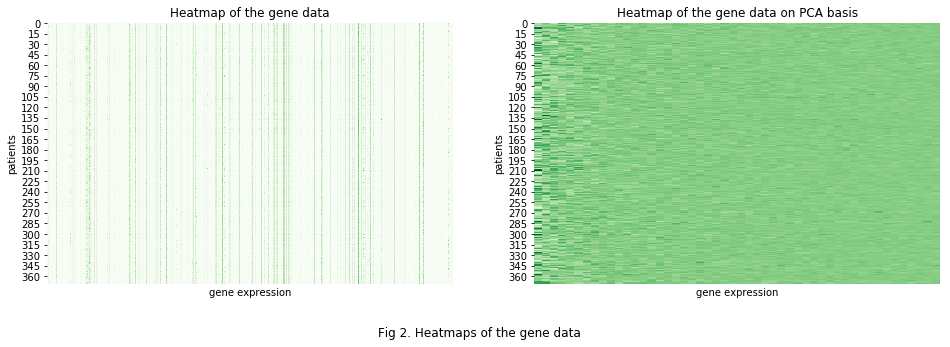

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(16, 4.8))
sns.heatmap(adata.X, cmap="Greens", ax=axs[0], xticklabels=[], cbar=False)
axs[0].set_title("Heatmap of the gene data")
axs[0].set_xlabel("gene expression")
axs[0].set_ylabel("patients")
# take PCA transformations
sc.pp.pca(adata, n_comps=50)
sc.pp.neighbors(adata)
sns.heatmap(adata.obsm['X_pca'], cmap="Greens", ax=axs[1], xticklabels=[], cbar=False);
axs[1].set_title("Heatmap of the gene data on PCA basis")
axs[1].set_xlabel("gene expression")
axs[1].set_ylabel("patients")
fig.suptitle("Fig 2. Heatmaps of the gene data", y=0);

### 2.1.2. Clustering 
Among many clustering algorithms, we choose to use Louvain algorithm. Louvain algorithm \cite{blondel2008fast} are adapted from network theorem and has great performance on clustering gene expressions. Louvain algorithm works by first constructing a neighborhood graph , which is to assign edges based on Euclidean distance among genes. Then, Louvain algorithm tends to find "communities", which are subgroups of genes that are closed and have many connections in the neighborhood graph. Compare to distance based clustering algorithm such as k-nearest neighbors, Louvain algorithm tends to capture the internal connections based on the number of points within some distance. Rather than finding hyper-balls shaped clusters by kNN, Louvain algorithm can find various clusters with different shapes. 

## 2.2. Other Factors from Clinical Data

In [5]:
sc.tl.louvain(adata)
sc.tl.umap(adata)
sc.tl.dendrogram(adata, groupby="louvain");


def create_survival_data(row):
    death_days = int(row['days_to_death']) if row['days_to_death'] != "--" else -1
    follow_up_days = int(row['days_to_last_follow_up']) if row['days_to_last_follow_up'] != "--" else -1
    row['duration'] = max(death_days, follow_up_days)
    row['status'] = row['vital_status'] == "Dead"
    return row

df = clinical[['submitter_id', 'age_at_index', 'gender', 'vital_status',
       'days_to_death', 'days_to_last_follow_up', 'tumor_stage']].copy()
df = df.apply(create_survival_data, axis=1)
df = df.loc[np.logical_and(df['vital_status'] != "Not Reported", df['duration'] > -1)]
df['status'] = df['status'].astype(int)
df = df.drop(["vital_status", "days_to_death", "days_to_last_follow_up"], axis=1)
df = df.merge(adata.obs.reset_index(), left_on="submitter_id", right_on="index").drop("index", axis=1)

In [6]:
df_fit = df.copy()
df_fit = df_fit.drop("submitter_id", axis=1)
df_fit['gender'] = (df_fit.gender == "male").astype(int)
def map_tumor_stage(x):
    if x == "stage i":
        return 1
    elif x == "stage ii":
        return 2
    elif "stage iii" in x:
        return 3
    elif "stage iv" in x:
        return 4
    else:
        return np.nan
df_fit['tumor_stage'] = df_fit['tumor_stage'].apply(map_tumor_stage)

In [7]:
def apply_dendrogram(x):
    if int(x) == 2 or int(x) == 4:
        return 1
    elif int(x) == 0 or int(x) == 3:
        return 2
    else:
        return 3
df_fit['louvain'] = df_fit['louvain'].astype(int)
df_fit['louvain_h'] = df_fit['louvain'].apply(apply_dendrogram)

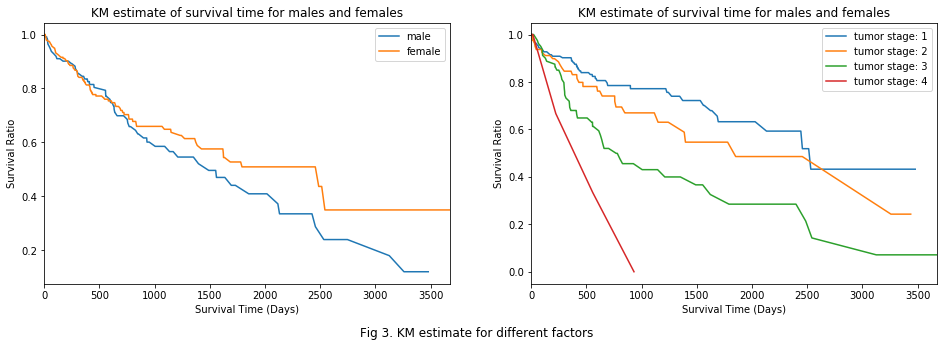

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(16, 4.8))
for i in range(2):
    kmf = ls.KaplanMeierFitter()
    df = df_fit.loc[df_fit['gender'].astype(int) == i]
    kmf.fit(df['duration'], event_observed=df['status'])
    kmf.survival_function_.plot(ax=axs[0])
axs[0].set_title("KM estimate of survival time for males and females")
axs[0].set_xlabel("Survival Time (Days)")
axs[0].set_ylabel("Survival Ratio")
axs[0].legend(["male", "female", "baseline"]);

for i in range(1, 5):
    kmf = ls.KaplanMeierFitter()
    df = df_fit.loc[df_fit['tumor_stage'] == i]
    kmf.fit(df['duration'], event_observed=df['status'])
    kmf.survival_function_.plot(ax=axs[1])
axs[1].set_title("KM estimate of survival time for males and females")
axs[1].set_xlabel("Survival Time (Days)")
axs[1].set_ylabel("Survival Ratio")
axs[1].legend([f"tumor stage: {i}" for i in range(1, 5)])
fig.suptitle("Fig 3. KM estimate for different factors", y=0.);

Taking consideration of other clinical factors, including age at the diagnosis, tumor stage, and gender. Naturally, the aged people are more likely to be diagnosed with cancers. Which is reflected in our dataset, as the majority of the patients are centered around 60. However, due to the low variations of age in our dataset, evaluating the relationship between age and survival time is hard. In addition, tumor stages definitely have decisive impact on the survival time, as shown in Fig 5. Finally, there is no evidence that gender is related to survival, as shown in the survival curve. Also, note that the number of observations between 

## 2.3. Models
From the investigations above, two Cox regression models are proposed. The additive model considers the effect of gene clusters, age, and tumor stage on survival time. The interaction model, in addition, consider the interactions of gene clusters vs. age and gene clusters vs. tumor stage. The models are given as 
$$h_1 = \text{baseline} \cdot \exp(\beta_1\overline{\text{cluster}} + \beta_2\overline{\text{tumor}} + \beta_3\overline{\text{age}})$$
$$h_2 = \text{baseline} \cdot \exp(\beta_1\overline{\text{cluster}} + \beta_2\overline{\text{tumor}} + \beta_3\overline{\text{age}} + \beta_4\overline{\text{cluster:tumor}} + \beta_5\overline{\text{cluster:age}})$$
where $\overline{\text{group}}$ are zero-centered observations.
We use the interactive model to assess whether the gene clusters is correlated with age or tumor stage. On the other words, whether the gene groups is a unique predictor that can provide additional information than clinical observations.

# 3. Results

The clusters of genes are plotted on a 2D UMAP\cite{lel2018umap} basis. UMAP is a non-linear dimension reduction algorithm that approximates a manifold from the neighborhood graph. UMAP tends to give a more intuitive visualization of the distance and connections. We also show the dendrogram to see the hierarchical clusters. 

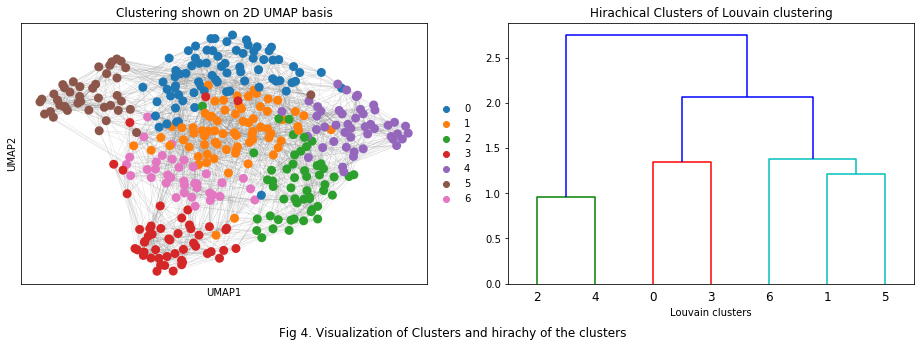

In [9]:
# try UMAP embedding
# do neighborhood and Louvain clustering
from scipy.cluster import hierarchy
fig, axs = plt.subplots(1, 2, figsize=(16, 4.8))
fig.suptitle("Fig 4. Visualization of Clusters and hirachy of the clusters", y=0)
hierarchy.dendrogram(adata.uns['dendrogram_louvain']['linkage'], ax=axs[1])
axs[1].set_title("Hirachical Clusters of Louvain clustering")
axs[1].set_xlabel("Louvain clusters")
sc.pl.umap(adata, color="louvain", edges=True, 
           title="Clustering shown on 2D UMAP basis", ax=axs[0]);

The performance of our clusters on survival time is evaluated through Kaplan-Meier estimate. However, from the plot, we see some of the clusters from the Louvain algorithm have very similar similar survival curve, hence we will use 3 clusters from hierarchical clusters at level 2 of the dendrogram. 

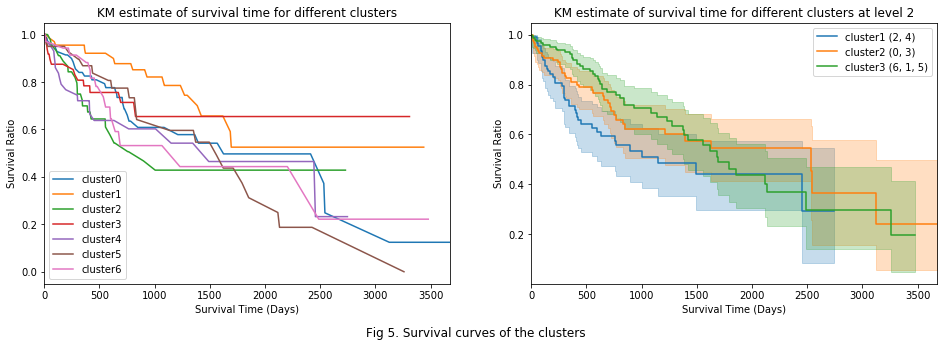

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(16, 4.8))

for i in range(7):
    kmf = ls.KaplanMeierFitter()
    df = df_fit.loc[df_fit['louvain'].astype(int) == i]
    kmf.fit(df['duration'], event_observed=df['status'])
    kmf.survival_function_.plot(ax=axs[0])

axs[0].set_title("KM estimate of survival time for different clusters")
axs[0].set_xlabel("Survival Time (Days)")
axs[0].set_ylabel("Survival Ratio");
axs[0].legend([f"cluster{i}" for i in range(7)])
for i in range(1, 4):
    kmf = ls.KaplanMeierFitter()
    df = df_fit.loc[df_fit['louvain_h'] == i]
    kmf.fit(df['duration'], event_observed=df['status'])
    kmf.plot(ax=axs[1], label=f"cluster{i}")

axs[1].set_title("KM estimate of survival time for different clusters at level 2")
axs[1].set_xlabel("Survival Time (Days)")
axs[1].set_ylabel("Survival Ratio")
axs[1].legend(['cluster1 (2, 4)', 'cluster2 (0, 3)', 'cluster3 (6, 1, 5)'])
fig.suptitle("Fig 5. Survival curves of the clusters", y=0.);

df_fit.to_csv("df_fit.csv", index=False)

Then, we fit the regression models based on the clusters and the coefficients of the fitted models are shown below. 

In [11]:
# df_fit.to_csv("df_fit.csv", index=False)

In [12]:
# library(survival)
# df <- read.csv("df_fit.csv")

In [13]:
# cox.model_add <- coxph(Surv(duration, status) ~ as.factor(louvain_h) + as.factor(tumor_stage) + age_at_index, data = df)
# cox.model_int <- coxph(Surv(duration, status) ~ as.factor(louvain_h) * as.factor(tumor_stage) + as.factor(louvain_h) * age_at_index, data = df)

# write.csv(as.data.frame(summary(cox.model_add)$coef), "model1coef.csv")
# write.csv(as.data.frame(summary(cox.model_int)$coef), "model2coef.csv")

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Latex
coefs_1 = pd.read_csv("model1coef.csv").iloc[:, [0, 1, 5]]
coefs_1.columns = ['name', 'coef.', 'p-value']
coefs_2 = pd.read_csv("model2coef.csv").iloc[:, [0, 1, 5]]
coefs_2.columns = ['name', 'coef.', 'p-value']
coefs = coefs_1.merge(coefs_2, on='name', how='outer', suffixes=(' of model1', ' of model2'))
coefs.name = coefs.name.apply(lambda x: x.replace("as.factor(", "").replace(")", "="))
coefs = coefs.fillna("")
display(Latex(coefs.to_latex(index=False)));

<IPython.core.display.Latex object>

The p-values of all interaction terms are extremely large. In addition, the overall p-values in model 2 are much larger than model 1. This observation hints multicollinearity problem in model 2. Therefore, we conclude that there is no clues of interactions for cluster vs. tumor stage and cluster vs. age. In addition, the independence of cluster vs. age and cluster vs. age is hinted in Fig 6, where the distributions are similar among cluster groups. 

For coefficients in model 1, there is some evidence that the clusters is associated with survival time. Although this association is much weaker than tumor stage. Because the p-value is still close to 0.05 and the model does not fit quite well, this clustering may still be insignificant. 

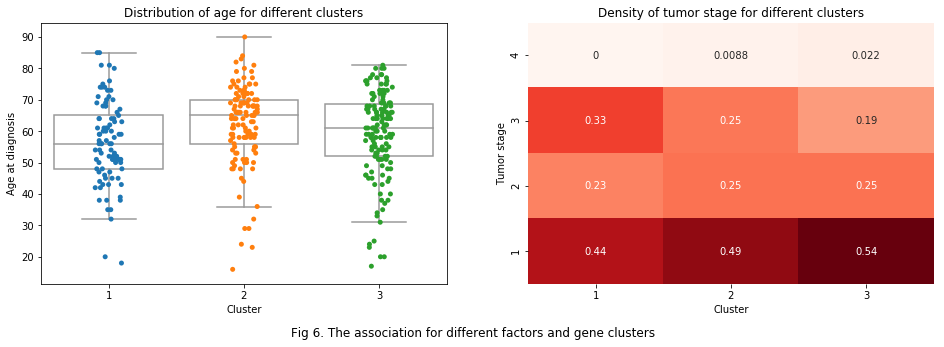

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(16, 4.8))
sns.boxplot(x=df_fit['louvain_h'], y=df_fit['age_at_index'], ax=axs[0], color="white", showfliers = False)
sns.stripplot(x=df_fit['louvain_h'], y=df_fit['age_at_index'], ax=axs[0])
axs[0].set_title("Distribution of age for different clusters")
axs[0].set_ylabel("Age at diagnosis")
axs[0].set_xlabel("Cluster")
hm = np.empty((4, 3))
for i in range(3):
    for j in range(4):
        hm[3-j, i] = len(df_fit.loc[np.logical_and(df_fit['louvain_h'] == i + 1, df_fit["tumor_stage"] == j + 1)])
hm /= hm.sum(axis=0)
sns.heatmap(hm, cmap="Reds", ax=axs[1], annot=True, cbar=False)
axs[1].set_xticklabels([1, 2, 3])
axs[1].set_yticklabels([4, 3, 2, 1])
axs[1].set_xlabel("Cluster")
axs[1].set_ylabel("Tumor stage")
axs[1].set_title("Density of tumor stage for different clusters")
fig.suptitle("Fig 6. The association for different factors and gene clusters", y=0.);

# 4. Conclusion

In conclusion, the gene subgroups that found by PCA dimension reduction and Louvain algorithm provide some clues of survival times for the patients with liver cancer. In addition, the gene clustering information is likely to be independent of the observed clinical information, such as age, gender, and tumor stage. Therefore, measuring the genes of the patients can provide unique information for the treatment plan. 

However, we have to notice that the Cox regression fit is not quite good, and the coefficients of the clusters are just below 0.05. Because the dimensionality of genes is much greater than the number of observations, this model may not be generalized to other cancer cases. Further validations and testings should be conducted on other cases to measure the performance of this clustering procedure. In addition, these gene clusters can correlate with some clinical factors that is not examined, and the clusters may not have unique and independent impact on the severity of the cancer. We need to consider more clinical factors that may be correlated with the gene clusters. 

\bibliographystyle{unsrt}
\bibliography{ref}